In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
# 2. Đọc file dữ liệu chứng khoán Eximbank và chia tập train test theo tỉ lệ 8:2
df = pd.read_csv('Eximbank.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15026.178, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15037.750, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15025.668, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15027.206, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15035.796, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15024.196, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15025.577, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15024.791, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15023.220, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15024.830, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15024.742, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15021.169, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15025.239, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15023.698, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
model = VARMAX(train_data, order=(1, 1))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [6]:
# 5. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Tạo một mảng gồm 30 số nguyên liên tiếp bắt đầu từ last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá đóng cho 30 ngày tiếp theo
close_next_30_days = model_fit.forecast(steps=len(x_next_30_days))

y_next_30_days = close_next_30_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 30 ngày tiếp theo
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[15257.5566145  15262.26101982 15262.92262673 15261.2305946
 15258.16989472 15254.31487409 15250.00043757 15245.42186714
 15240.69302829 15235.88031112 15231.02242206 15226.14192469
 15221.25196943 15216.36021775 15211.47113041 15206.58730182
 15201.71023806 15196.84081066 15191.97952107 15187.12665502
 15182.28237241 15177.44675982 15172.61986106 15167.80169501
 15162.99226606 15158.19157012 15153.3995982  15148.61633843
 15143.84177732 15139.07590041]


In [7]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 3695.9606134019427


In [8]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 17.68385125701191


In [9]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 3300.5373194616323


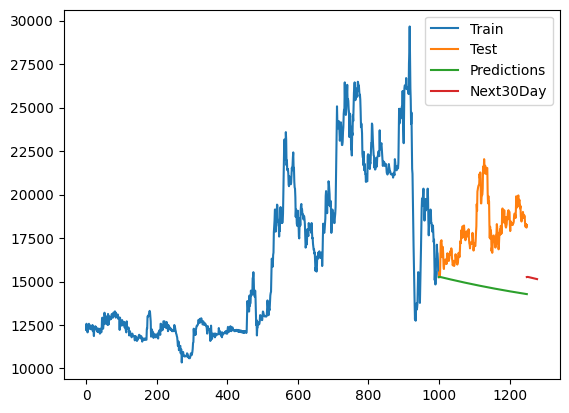

In [10]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

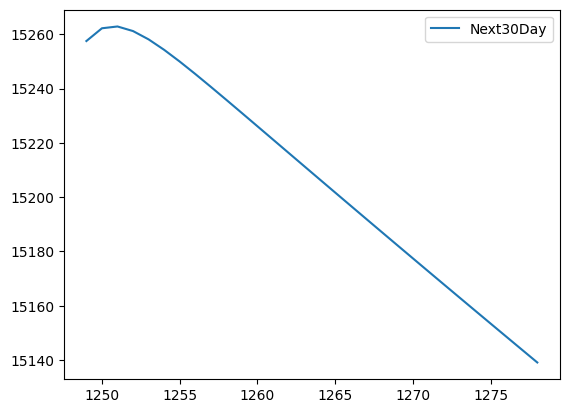

In [11]:
plt.plot(last_data,y_next_30_days)
plt.legend(['Next30Day'])
plt.show()